# **SEBAL Analysis of Daily ETa Rasters**

In [1]:

# Loading packages
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import box
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress
from scipy.stats import variation,zscore
import xarray as xr
import rioxarray as rxr
import rasterio as rio
from rasterio.enums import Resampling
from rasterio.merge import merge
from rioxarray.merge import merge_arrays
from rasterio.warp import reproject, Resampling, calculate_default_transform
from rasterio.plot import show
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import math
import random
import seaborn as sns
import itertools


# Loading geocube to raterize vector polygons (https://github.com/corteva/geocube)
from geocube.api.core import make_geocube

import spyndex
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import tarfile
import pathlib
#import geowombat




import glob
import os
import os.path
import sys

In [2]:
# Import SPAEF Function from https://github.com/cuneyd/spaef
import SPAEF_metric as sp

In [3]:
# import required modules
import numpy as np
from scipy.stats import variation,zscore
import math
######################################################################################################################
def filter_nan(s,o):
    data = np.transpose(np.array([s.flatten(),o.flatten()]))
    data = data[~np.isnan(data).any(1)]
    return data[:,0], data[:,1]
######################################################################################################################
def SPAEF(s, o):
    #remove NANs    
    s,o = filter_nan(s,o)
    
    bins_float=np.around(math.sqrt(len(o)),0)
    bins=int(bins_float)
    #compute corr coeff
    alpha = np.corrcoef(s,o)[0,1]
    #compute ratio of CV
    beta = variation(s)/variation(o)
    #compute zscore mean=0, std=1
    o=zscore(o)
    s=zscore(s)
    #compute histograms
    hobs,binobs = np.histogram(o,bins)
    hsim,binsim = np.histogram(s,bins)
    #convert int to float, critical conversion for the result
    hobs=np.float64(hobs)
    hsim=np.float64(hsim)
    #find the overlapping of two histogram      
    minima = np.minimum(hsim, hobs)
    #compute the fraction of intersection area to the observed histogram area, hist intersection/overlap index   
    gamma = np.sum(minima)/np.sum(hobs)
    #compute SPAEF finally with three vital components
    spaef = 1- np.sqrt( (alpha-1)**2 + (beta-1)**2 + (gamma-1)**2 )  

    return spaef, alpha, beta, gamma
######################################################################################################################

In [4]:
# Insert Start of data directory 
# path_data = "../../DATA_MesoHyd_MA-SEBAL/"   # Path data SC_UL
path_data = "D:/Nicolas_D/Geodaten/Masterarbeit/DATA_MesoHyd_MA-SEBAL/" # Path data NICOLAS-PC

# Plot Path
path_plots = "D:/Nicolas_D/Geodaten/Masterarbeit/DATA_MesoHyd_MA-SEBAL/Processed/export/images_first_analysis/"


In [5]:
# Set date(s) of modelling/data retrieval
# date = "2015-07-04"  # Initial LS Picture
date = "2015-04-15"
date = pd.to_datetime(date, format = "%Y-%m-%d")
print("Date normal =", date)


# Date in meteo_raster_daily Path Format
date_met = date.date()
date_met = date_met.strftime('%Y-%m-%d')
print("Date INTERMET =", date_met)


# Date in WASIM-Raster Path Format
date_wasim = date.date()
date_wasim = date_wasim.strftime('%Y_%m_%d').replace("_0", "_").replace("_", "_")
print("Date WASIM =", date_wasim)


# Date in ETp-FAO56-Raster Path Format
date_etp = date.date()
date_etp = date_etp.strftime('%Y_%m_%d').replace("_0", "-").replace("_", "-")
print("Date ETp =", date_etp)


# Date SSEB Format
date_SSEB = date.date()
date_SSEB = date_SSEB.strftime('%Y_%m_%d').replace("-", "_")
print("Date SSEB =", date_SSEB)

# Date in Landsat Path Format
date_LS = date.date()
date_LS = date_LS.strftime('%Y%m%d')
print("Date Landsat =", date_LS)


Date normal = 2015-04-15 00:00:00
Date INTERMET = 2015-04-15
Date WASIM = 2015_4_15
Date ETp = 2015-4-15
Date SSEB = 2015_04_15
Date Landsat = 20150415


# Import Data

### Import Catchment Shapes

In [6]:
# 0. Path for GeoTIFF
stack_name = "LS08_" + date_LS + ".tif"
stack_path = path_data + "Processed/LANDSAT/LS_Processed/" + stack_name

# Load Shapefile for Catchments
path_shapeA = path_data + "Processed/study_area/altenbamberg_catchment.gpkg"
shape_alten = gpd.read_file(path_shapeA)

path_shapeK = path_data + "Processed/study_area/kellenbach_catchment.gpkg"
shape_kellen = gpd.read_file(path_shapeK)

# Combine both Catchment Shapes
shape_catchments = pd.concat([shape_alten, shape_kellen])

### Import SEBAL ETa Map

In [7]:
# Export ETa_day Raster 
export_path = path_data + "Processed/export/eta_day/ETa_day_" + date_SSEB + ".tif"


In [8]:
eta_day = rxr.open_rasterio(export_path, masked = True).squeeze()

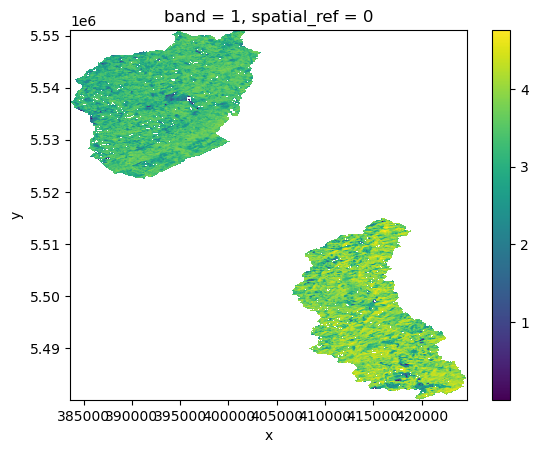

In [9]:
eta_day.plot()

In [11]:
export_path = path_data + "Processed/SEBAL_raster_export/SEBAL_" + date_SSEB + ".tif"
raster = eta_day  # xarray Array to be exported

raster.rio.to_raster(export_path)

### Import CORINE Land Cover Map

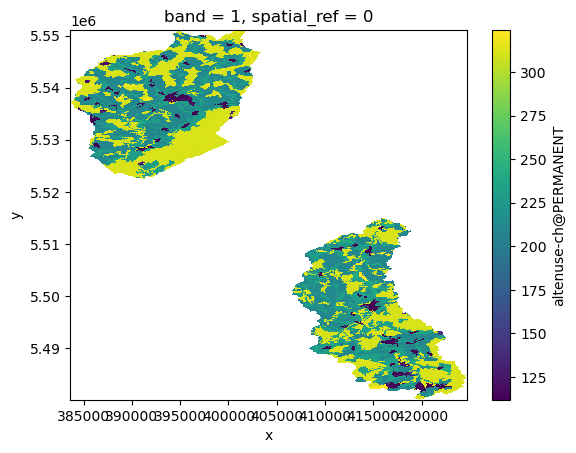

In [12]:
# Open Corine Land Use Maps for both catchments
path_LUA = path_data + "Original/study_area/altenuse-ch.tif"
LU_alten = rxr.open_rasterio(path_LUA).squeeze()


path_LUK = path_data + "Original/study_area/kelleuse-ch.tif"
LU_kellen = rxr.open_rasterio(path_LUK).squeeze()

# Merge raster
LU_mosaic = merge_arrays(dataarrays = [LU_alten, LU_kellen], nodata = np.nan)
#LU_mosaic = LU_mosaic .rename({"x": "long", "y": "lat"})
LU_mosaic.rio.write_crs("epsg:32632", inplace=True)

# Reproject and Resample Land Use Raster

# Using reproject_match https://corteva.github.io/rioxarray/html/examples/reproject_match.html
xds_match = eta_day
xds = LU_mosaic
xds_repr_match = xds.rio.reproject_match(xds_match)

xds_repr_match = xds_repr_match.assign_coords({
    "x": xds_match.x,
    "y": xds_match.y,
})

LU_mosaic = xds_repr_match

LU_mosaic.plot()


In [13]:
print(np.unique(LU_mosaic))
print(len(np.unique(LU_mosaic)))

[112. 121. 131. 132. 142. 211. 221. 231. 242. 243. 311. 312. 313. 322.
 324.  nan]
16


In [14]:
# Combine with Land Cover Key Table
LU_table_path = "../../data/clc_legend.csv"
LU_table = pd.read_csv(LU_table_path) #delimiter = "\t", header = [3]
#print(LU_table)

LU_agri = [211, 212, 221, 222, 223, 241, 242, 243, 244]
LU_bare = [331, 332, 333, 334, 131]
LU_grass = [231, 321, 322, 323, 324, 411, 412]
LU_urban = [111, 112, 121, 122, 123, 124, 132, 133, 141, 142]
LU_forest = [311, 312, 313]
LU_water = [511, 512, 335]

# Create filters from Land Use classes
agri_filter = np.isin(LU_mosaic.values, LU_agri)
bare_filter = np.isin(LU_mosaic.values, LU_bare)
grass_filter = np.isin(LU_mosaic.values, LU_grass)
urban_filter = np.isin(LU_mosaic.values, LU_urban)
forest_filter = np.isin(LU_mosaic.values, LU_forest)
water_filter = np.isin(LU_mosaic.values, LU_water)

### Results Lists

In [15]:
# Full regression
WASIM_fullreg = []
SSEB_fullreg = []
EEFlux_fullreg = []

# Agri
WASIM_agri = []
SSEB_agri = []
EEFlux_agri = []

# Bare Soil
WASIM_bare = []
SSEB_bare = []
EEFlux_bare = []

# Grass
WASIM_grass = []
SSEB_grass = []
EEFlux_grass = []

# Urban
WASIM_urban = []
SSEB_urban = []
EEFlux_urban = []

# Forest
WASIM_forest = []
SSEB_forest = []
EEFlux_forest = []

# WASIM ETa Raster

### Load data

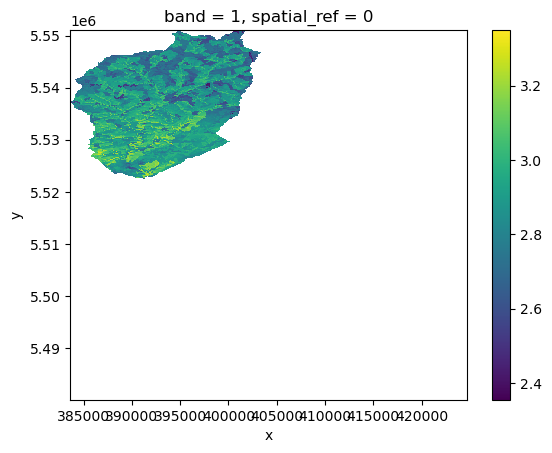

In [16]:
# Open WASIM Raster
path_wasim_kelle = path_data + "Original/WASIM_raster/etr_kelle_" + date_SSEB + ".tif"
wasim_kelle = rxr.open_rasterio(path_wasim_kelle, masked = True).squeeze()

# Merge raster
#LU_mosaic = merge_arrays(dataarrays = [LU_alten, LU_kellen], nodata = np.nan)
#LU_mosaic = LU_mosaic .rename({"x": "long", "y": "lat"})
wasim = wasim_kelle # + merged wasim altenbamberg
wasim.rio.write_crs("epsg:32632", inplace=True)

# Reproject and Resample Land Use Raster

# Using reproject_match https://corteva.github.io/rioxarray/html/examples/reproject_match.html
xds_match = eta_day
xds = wasim
xds_repr_match = xds.rio.reproject_match(xds_match)

xds_repr_match = xds_repr_match.assign_coords({
    "x": xds_match.x,
    "y": xds_match.y,
})

wasim = xds_repr_match

wasim.plot()

In [19]:
export_path = path_data + "Processed/WASIM_raster_export/etr_kelle_" + date_SSEB + ".tif"
raster = wasim  # xarray Array to be exported

raster.rio.to_raster(export_path)

### Scatterplot, simple statistics

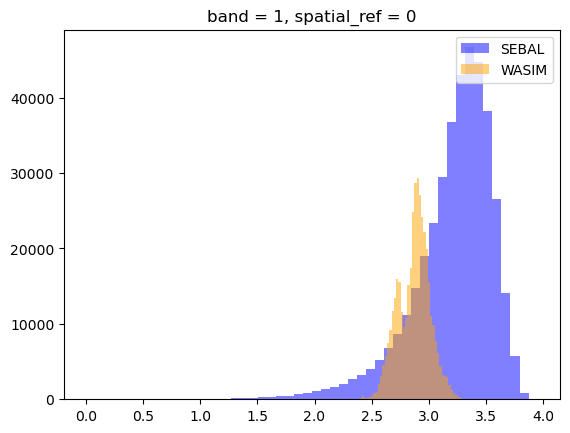

In [20]:
eta_kelle = eta_day.rio.clip(shape_kellen.geometry, all_touched = True)

eta_kelle.plot.hist(bins = 50, alpha = 0.5, color = "blue", label = "SEBAL")
wasim.plot.hist(bins = 50, alpha = 0.5, color = "orange", label = "WASIM")
plt.legend(loc='upper right')
plt.show()

Slope: 0.0647061104756825
Intercept: 2.6622097282776296
R-squared value: 0.02933881443556696
P-value: 0.0
Standard error: 0.000592030231344028


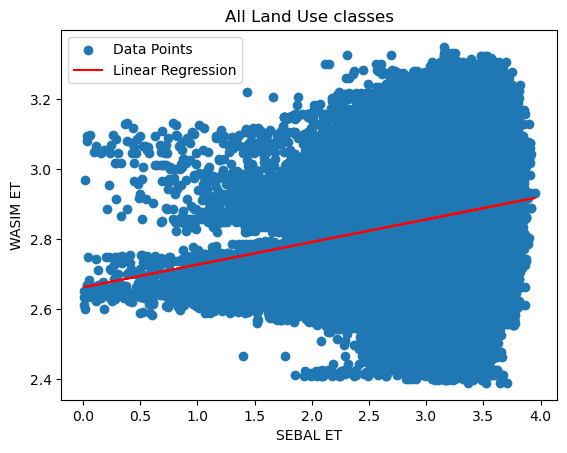

In [21]:
### Define Datasets 
title = "All Land Use classes"
x_name = "SEBAL ET"
y_name = "WASIM ET"

x_values = eta_day.values
y_values = wasim.values

# Remove NaN values
mask = ~np.isnan(x_values) & ~np.isnan(y_values)
x_values = x_values[mask]
y_values = y_values[mask]



### Linear Regression and Coefficients 
slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared value: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard error: {std_err}")


### Plot Regression
plt.scatter(x_values, y_values, label='Data Points')

# Plot the regression line
regression_line = slope * x_values + intercept
plt.plot(x_values, regression_line, color='red', label='Linear Regression')

# Labeling the plot
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.title(title)
plt.legend()


# Show the plot
plt.show()

# Append results to list
WASIM_fullreg.extend((slope, intercept, r_value**2, p_value, std_err))



### Statistics grouped by Land Use

https://earth-env-data-science.github.io/lectures/xarray/xarray-part2.html

Slope: -0.03843504133903746
Intercept: 3.0416553165753193
R-squared value: 0.032680490522964525
P-value: 0.0
Standard error: 0.0005629943573833107


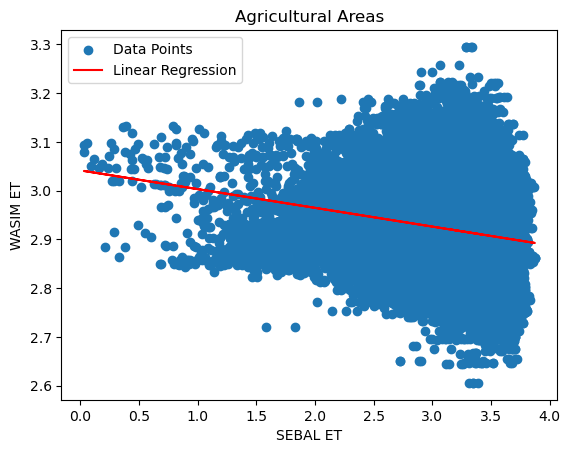

In [22]:
### Define Datasets 
title = "Agricultural Areas"
x_name = "SEBAL ET"
y_name = "WASIM ET"

x_values = eta_day.where(agri_filter).values
y_values = wasim.where(agri_filter).values

# Remove NaN values
mask = ~np.isnan(x_values) & ~np.isnan(y_values)
x_values = x_values[mask]
y_values = y_values[mask]



### Linear Regression and Coefficients 
slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared value: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard error: {std_err}")


### Plot Regression
plt.scatter(x_values, y_values, label='Data Points')

# Plot the regression line
regression_line = slope * x_values + intercept
plt.plot(x_values, regression_line, color='red', label='Linear Regression')

# Labeling the plot
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.title(title)
plt.legend()

# Show the plot
plt.show()

# Results to list
WASIM_agri.extend((slope, intercept, r_value**2, p_value, std_err))

Slope: 0.055118647709808344
Intercept: 2.821762481569669
R-squared value: 0.011151541616534017
P-value: 3.3779445426829773e-193
Standard error: 0.0018537526608627239


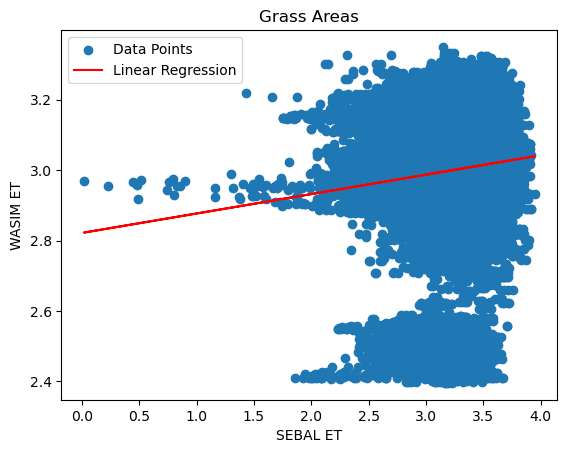

In [23]:
### Define Datasets 
title = "Grass Areas"
x_name = "SEBAL ET"
y_name = "WASIM ET"

x_values = eta_day.where(grass_filter).values
y_values = wasim.where(grass_filter).values

# Remove NaN values
mask = ~np.isnan(x_values) & ~np.isnan(y_values)
x_values = x_values[mask]
y_values = y_values[mask]



### Linear Regression and Coefficients 
slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared value: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard error: {std_err}")


### Plot Regression
plt.scatter(x_values, y_values, label='Data Points')

# Plot the regression line
regression_line = slope * x_values + intercept
plt.plot(x_values, regression_line, color='red', label='Linear Regression')

# Labeling the plot
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.title(title)
plt.legend()

# Show the plot
plt.show()

# Results to list
WASIM_grass.extend((slope, intercept, r_value**2, p_value, std_err))

Slope: 0.058302321160862126
Intercept: 2.5968598994477423
R-squared value: 0.03029226818969339
P-value: 0.0
Standard error: 0.0008183348900369933


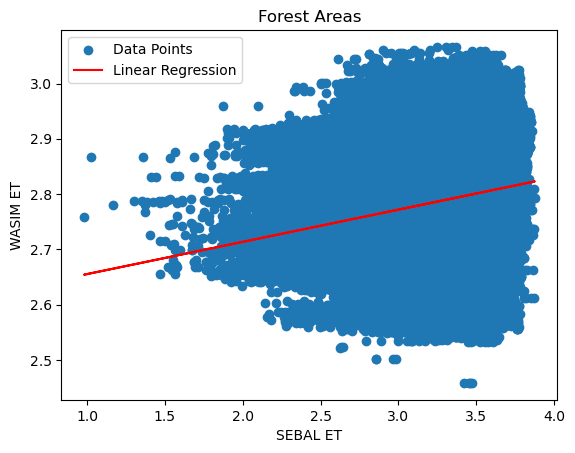

In [24]:
### Define Datasets 
title = "Forest Areas"
x_name = "SEBAL ET"
y_name = "WASIM ET"

x_values = eta_day.where(forest_filter).values
y_values = wasim.where(forest_filter).values

# Remove NaN values
mask = ~np.isnan(x_values) & ~np.isnan(y_values)
x_values = x_values[mask]
y_values = y_values[mask]



### Linear Regression and Coefficients 
slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared value: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard error: {std_err}")


### Plot Regression
plt.scatter(x_values, y_values, label='Data Points')

# Plot the regression line
regression_line = slope * x_values + intercept
plt.plot(x_values, regression_line, color='red', label='Linear Regression')

# Labeling the plot
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.title(title)
plt.legend()

# Show the plot
plt.show()

# Results to list
WASIM_forest.extend((slope, intercept, r_value**2, p_value, std_err))

Slope: -0.07198462600751379
Intercept: 2.8778875443397123
R-squared value: 0.20317953441670086
P-value: 4.249621133117587e-25
Standard error: 0.006561588834356363


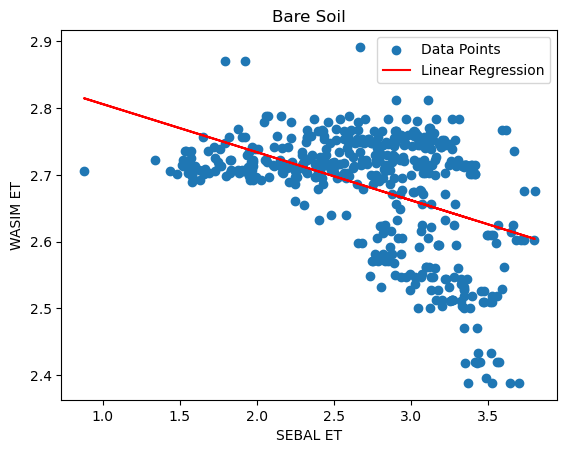

In [25]:
### Define Datasets 
title = "Bare Soil"
x_name = "SEBAL ET"
y_name = "WASIM ET"

x_values = eta_day.where(bare_filter).values
y_values = wasim.where(bare_filter).values

# Remove NaN values
mask = ~np.isnan(x_values) & ~np.isnan(y_values)
x_values = x_values[mask]
y_values = y_values[mask]



### Linear Regression and Coefficients 
slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared value: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard error: {std_err}")


### Plot Regression
plt.scatter(x_values, y_values, label='Data Points')

# Plot the regression line
regression_line = slope * x_values + intercept
plt.plot(x_values, regression_line, color='red', label='Linear Regression')

# Labeling the plot
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.title(title)
plt.legend()

# Show the plot
plt.show()

# Results to list
WASIM_bare.extend((slope, intercept, r_value**2, p_value, std_err))

Slope: 0.001772458880832
Intercept: 2.675813810071317
R-squared value: 0.00012605247540861328
P-value: 0.15690609727050955
Standard error: 0.00125207164005821


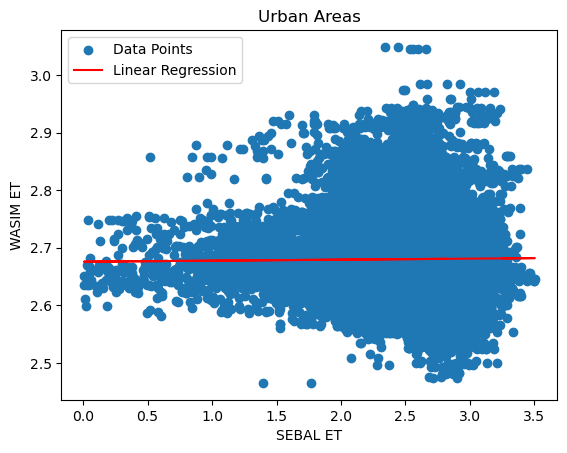

In [26]:
### Define Datasets 
title = "Urban Areas"
x_name = "SEBAL ET"
y_name = "WASIM ET"

x_values = eta_day.where(urban_filter).values
y_values = wasim.where(urban_filter).values

# Remove NaN values
mask = ~np.isnan(x_values) & ~np.isnan(y_values)
x_values = x_values[mask]
y_values = y_values[mask]



### Linear Regression and Coefficients 
slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared value: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard error: {std_err}")


### Plot Regression
plt.scatter(x_values, y_values, label='Data Points')

# Plot the regression line
regression_line = slope * x_values + intercept
plt.plot(x_values, regression_line, color='red', label='Linear Regression')

# Labeling the plot
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.title(title)
plt.legend()

# Show the plot
plt.show()

# Results to list
WASIM_urban.extend((slope, intercept, r_value**2, p_value, std_err))

### SPAEF WASIM

In [27]:
SPAEF(wasim.values, eta_day.values)

(-0.30610150019758864,
 0.17128576833924927,
 0.42228984788410434,
 0.17212027974859062)

# SSEB Raster

### Load data

['D:/Nicolas_D/Geodaten/Masterarbeit/DATA_MesoHyd_MA-SEBAL/Original/SSEB\\Landsat8_MesoHyd_2015_04_15_ETa_SSEB_Alten_v2.tif', 'D:/Nicolas_D/Geodaten/Masterarbeit/DATA_MesoHyd_MA-SEBAL/Original/SSEB\\Landsat8_MesoHyd_2015_04_15_ETa_SSEB_Kellen_v2.tif']


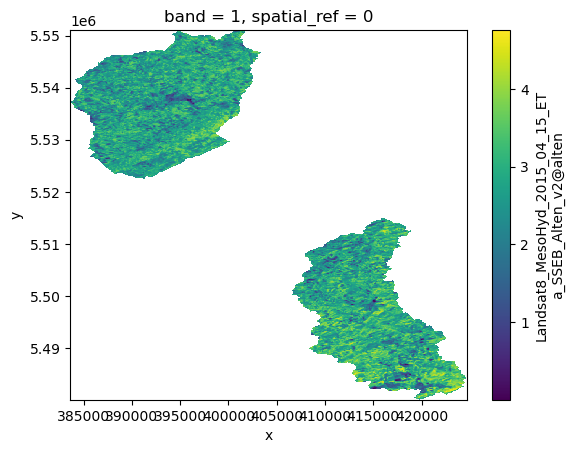

In [64]:
# DATA FROM SSEB

# Date in SSEB-Raster Path Format with time (hour)

# Create Path for recursive file search based on defined date
path_SSEB = path_data + "Original/SSEB/"
pattern = f"*{date_SSEB}*.tif"
paths_SSEB = sorted(glob.glob(os.path.join(path_SSEB, "**", pattern), recursive=True))
print(paths_SSEB)

# Combine both Rasters
raster_0 = rxr.open_rasterio(paths_SSEB[0]).squeeze()
raster_1 = rxr.open_rasterio(paths_SSEB[1]).squeeze()
SSEB_raster = merge_arrays(dataarrays = [raster_0, raster_1], nodata = np.nan)
SSEB_raster.rio.write_crs("epsg:32632", inplace=True)

# Clip raster by catchment vectors
SSEB_raster = SSEB_raster.rio.clip(shape_catchments.geometry, all_touched = True)


# Using reproject_match https://corteva.github.io/rioxarray/html/examples/reproject_match.html
xds_match = eta_day
xds = SSEB_raster
xds_repr_match = xds.rio.reproject_match(xds_match)



xds_repr_match = xds_repr_match.assign_coords({
    "x": xds_match.x,
    "y": xds_match.y,
})

SSEB_raster = xds_repr_match

SSEB_raster.plot()

In [65]:
export_path = path_data + "Processed/SSEB_raster_export/SSEB_" + date_SSEB + ".tif"
raster = SSEB_raster  # xarray Array to be exported

raster.rio.to_raster(export_path)

### Scatterplot, simple statistics

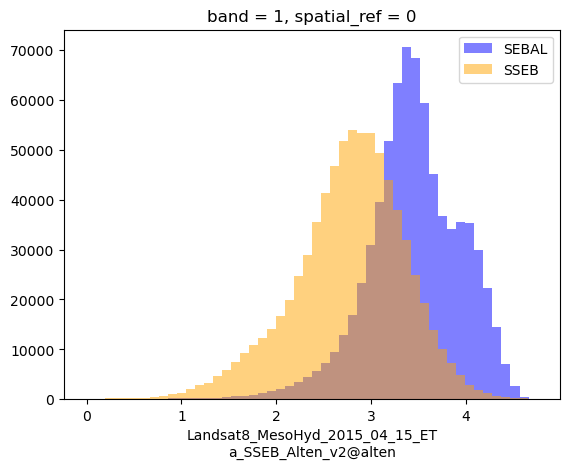

In [30]:
eta_day.plot.hist(bins = 50, alpha = 0.5, color = "blue", label = "SEBAL")
SSEB_raster.plot.hist(bins = 50, alpha = 0.5, color = "orange", label = "SSEB")
plt.legend(loc='upper right')
plt.show()

Slope: 0.9277052355837258
Intercept: -0.43450887757200807
R-squared value: 0.6358917928279111
P-value: 0.0
Standard error: 0.0008141036670931057


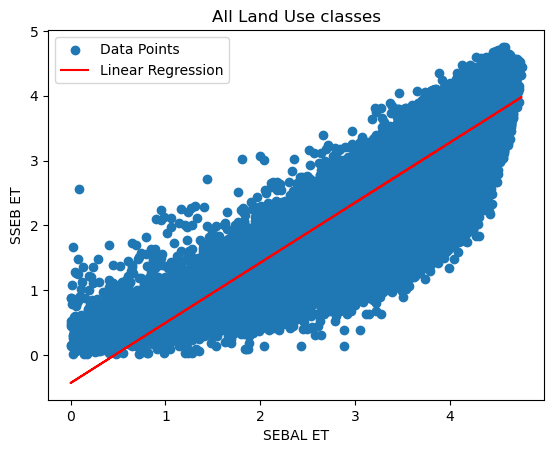

In [31]:
### Define Datasets 
title = "All Land Use classes"
x_name = "SEBAL ET"
y_name = "SSEB ET"

x_values = eta_day.values
y_values = SSEB_raster.values

# Remove NaN values
mask = ~np.isnan(x_values) & ~np.isnan(y_values)
x_values = x_values[mask]
y_values = y_values[mask]



### Linear Regression and Coefficients 
slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared value: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard error: {std_err}")


### Plot Regression
plt.scatter(x_values, y_values, label='Data Points')

# Plot the regression line
regression_line = slope * x_values + intercept
plt.plot(x_values, regression_line, color='red', label='Linear Regression')

# Labeling the plot
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.title(title)
plt.legend()


# Show the plot
plt.show()

# Results into List
SSEB_fullreg.extend((slope, intercept, r_value**2, p_value, std_err))

Slope: 0.9982163463733069
Intercept: -0.7357886579780182
R-squared value: 0.6064110784573162
P-value: 0.0
Standard error: 0.0015888819503923721


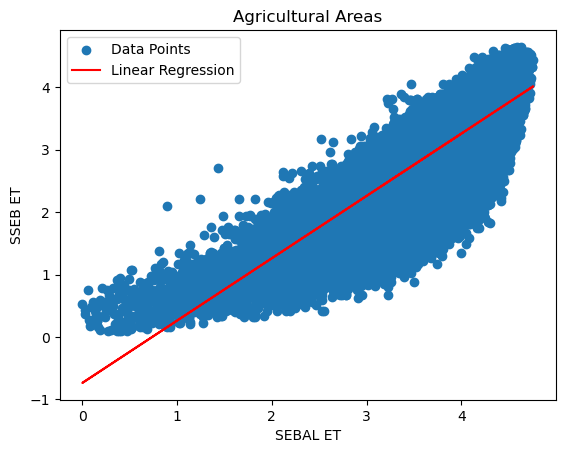

In [32]:
### Define Datasets 
title = "Agricultural Areas"
x_name = "SEBAL ET"
y_name = "SSEB ET"

x_values = eta_day.where(agri_filter).values
y_values = SSEB_raster.where(agri_filter).values

# Remove NaN values
mask = ~np.isnan(x_values) & ~np.isnan(y_values)
x_values = x_values[mask]
y_values = y_values[mask]



### Linear Regression and Coefficients 
slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared value: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard error: {std_err}")


### Plot Regression
plt.scatter(x_values, y_values, label='Data Points')

# Plot the regression line
regression_line = slope * x_values + intercept
plt.plot(x_values, regression_line, color='red', label='Linear Regression')

# Labeling the plot
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.title(title)
plt.legend()

# Show the plot
plt.show()

# Results into List
SSEB_agri.extend((slope, intercept, r_value**2, p_value, std_err))

Slope: 0.8426544667757833
Intercept: -0.2269795613131551
R-squared value: 0.5929423080669716
P-value: 0.0
Standard error: 0.0016842453903716174


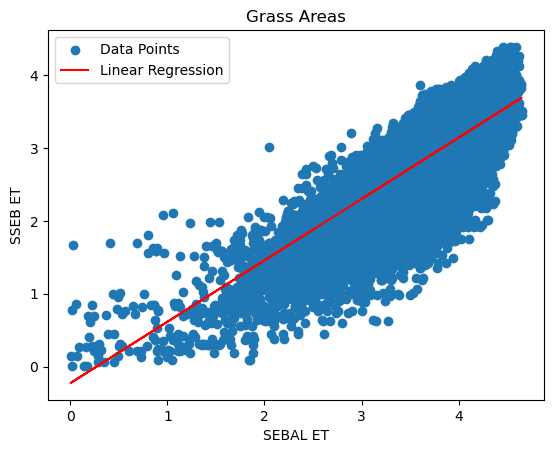

In [33]:
### Define Datasets 
title = "Grass Areas"
x_name = "SEBAL ET"
y_name = "SSEB ET"

x_values = eta_day.where(grass_filter).values
y_values = SSEB_raster.where(grass_filter).values

# Remove NaN values
mask = ~np.isnan(x_values) & ~np.isnan(y_values)
x_values = x_values[mask]
y_values = y_values[mask]



### Linear Regression and Coefficients 
slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared value: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard error: {std_err}")


### Plot Regression
plt.scatter(x_values, y_values, label='Data Points')

# Plot the regression line
regression_line = slope * x_values + intercept
plt.plot(x_values, regression_line, color='red', label='Linear Regression')

# Labeling the plot
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.title(title)
plt.legend()

# Show the plot
plt.show()

# Results into List
SSEB_grass.extend((slope, intercept, r_value**2, p_value, std_err))

Slope: 0.8974236874216346
Intercept: -0.19539832086216968
R-squared value: 0.663863599087015
P-value: 0.0
Standard error: 0.0012060658348766985


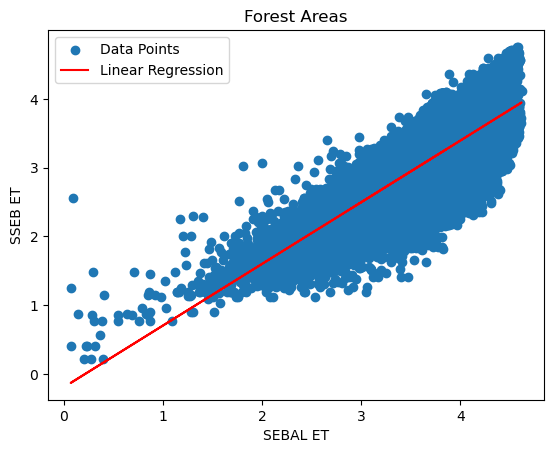

In [34]:
### Define Datasets 
title = "Forest Areas"
x_name = "SEBAL ET"
y_name = "SSEB ET"

x_values = eta_day.where(forest_filter).values
y_values = SSEB_raster.where(forest_filter).values

# Remove NaN values
mask = ~np.isnan(x_values) & ~np.isnan(y_values)
x_values = x_values[mask]
y_values = y_values[mask]



### Linear Regression and Coefficients 
slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared value: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard error: {std_err}")


### Plot Regression
plt.scatter(x_values, y_values, label='Data Points')

# Plot the regression line
regression_line = slope * x_values + intercept
plt.plot(x_values, regression_line, color='red', label='Linear Regression')

# Labeling the plot
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.title(title)
plt.legend()

# Show the plot
plt.show()

# Results into List
SSEB_forest.extend((slope, intercept, r_value**2, p_value, std_err))

Slope: 0.6104972587189209
Intercept: 0.12825003877734997
R-squared value: 0.6972626661213208
P-value: 1.493535838840531e-124
Standard error: 0.01851601413885179


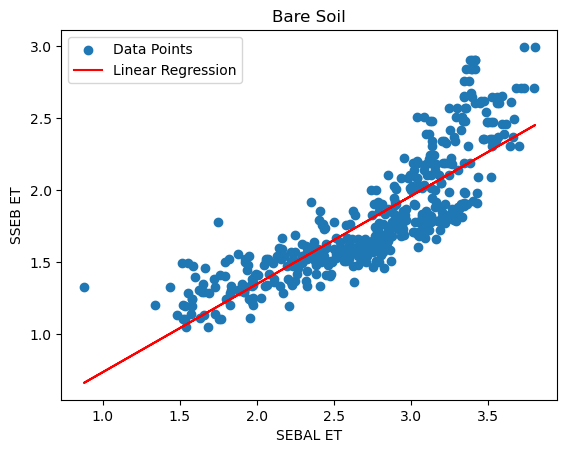

In [35]:
### Define Datasets 
title = "Bare Soil"
x_name = "SEBAL ET"
y_name = "SSEB ET"

x_values = eta_day.where(bare_filter).values
y_values = SSEB_raster.where(bare_filter).values

# Remove NaN values
mask = ~np.isnan(x_values) & ~np.isnan(y_values)
x_values = x_values[mask]
y_values = y_values[mask]



### Linear Regression and Coefficients 
slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared value: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard error: {std_err}")


### Plot Regression
plt.scatter(x_values, y_values, label='Data Points')

# Plot the regression line
regression_line = slope * x_values + intercept
plt.plot(x_values, regression_line, color='red', label='Linear Regression')

# Labeling the plot
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.title(title)
plt.legend()

# Show the plot
plt.show()

# Results into List
SSEB_bare.extend((slope, intercept, r_value**2, p_value, std_err))

Slope: 0.6531082803141409
Intercept: 0.09753742733517168
R-squared value: 0.6585393835099649
P-value: 0.0
Standard error: 0.002524569731194297


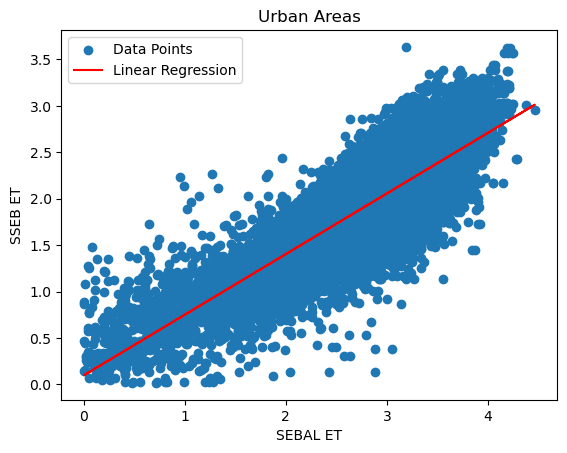

In [36]:
### Define Datasets 
title = "Urban Areas"
x_name = "SEBAL ET"
y_name = "SSEB ET"

x_values = eta_day.where(urban_filter).values
y_values = SSEB_raster.where(urban_filter).values

# Remove NaN values
mask = ~np.isnan(x_values) & ~np.isnan(y_values)
x_values = x_values[mask]
y_values = y_values[mask]



### Linear Regression and Coefficients 
slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared value: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard error: {std_err}")


### Plot Regression
plt.scatter(x_values, y_values, label='Data Points')

# Plot the regression line
regression_line = slope * x_values + intercept
plt.plot(x_values, regression_line, color='red', label='Linear Regression')

# Labeling the plot
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.title(title)
plt.legend()

# Show the plot
plt.show()

# Results into List
SSEB_urban.extend((slope, intercept, r_value**2, p_value, std_err))

Slope: 0.01608174025285096
Intercept: 2.8267838734269355
R-squared value: 0.00383372619513744
P-value: 0.0
Standard error: 0.0004089818033071681


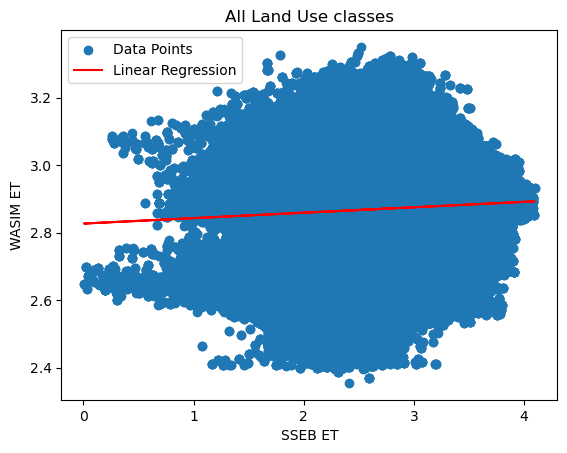

In [37]:
# WASIM AND SSEB
### Define Datasets 
title = "All Land Use classes"
x_name = "SSEB ET"
y_name = "WASIM ET"

x_values = SSEB_raster.values
y_values = wasim.values

# Remove NaN values
mask = ~np.isnan(x_values) & ~np.isnan(y_values)
x_values = x_values[mask]
y_values = y_values[mask]



### Linear Regression and Coefficients 
slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared value: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard error: {std_err}")


### Plot Regression
plt.scatter(x_values, y_values, label='Data Points')

# Plot the regression line
regression_line = slope * x_values + intercept
plt.plot(x_values, regression_line, color='red', label='Linear Regression')

# Labeling the plot
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.title(title)
plt.legend()


# Show the plot
plt.show()

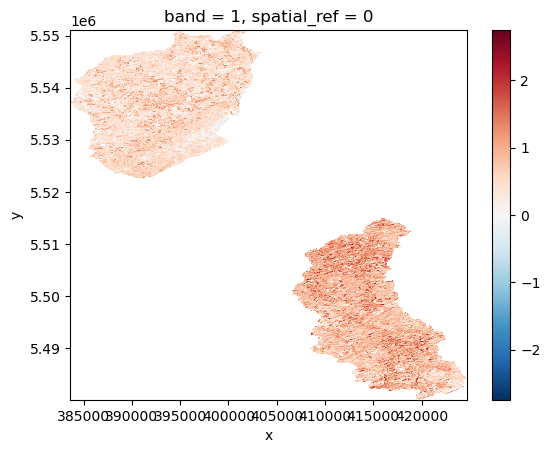

In [38]:
# Difference raster
diff = eta_day - SSEB_raster
diff.plot()

### SPAEF SSEB

In [39]:
SPAEF(eta_day.values, SSEB_raster.values)

(0.3659120590340772, 0.797428236788685, 0.6893181806879756, 0.4856956107742876)

In [40]:
SPAEF(SSEB_raster.values, eta_day.values)

(0.28677997023167767,
 0.7974282367886851,
 1.450708871485078,
 0.4856956107742876)

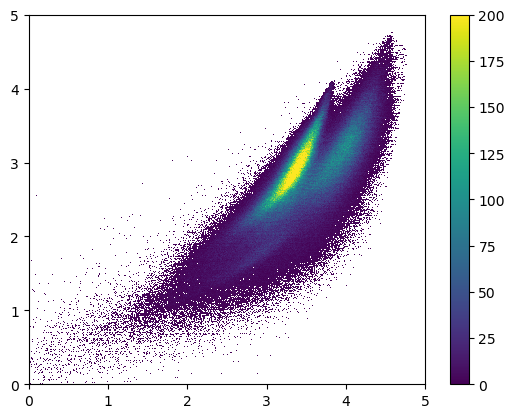

In [41]:
import datashader as ds
from datashader.mpl_ext import dsshow
import pandas as pd
import matplotlib.pyplot as plt

def using_datashader(ax, x, y):

    df = pd.DataFrame(dict(x=x, y=y))
    dsartist = dsshow(
        df,
        ds.Point("x", "y"),
        ds.count(),
        vmin=0,
        vmax=200,
        norm="linear",
        aspect="auto",
        ax=ax,
    )

    plt.colorbar(dsartist)
    
    # Set x and y axis limits
    ax.set_xlim(0, 5)
    ax.set_ylim(0, 5)





## Plot with Seaborn to plot density as well
x = eta_day.values.flatten()
y = SSEB_raster.values.flatten()

fig, ax = plt.subplots()
using_datashader(ax, x, y)

plt.show()


In [42]:
df = pd.DataFrame({"SEBAL": eta_day.values.flatten(),
                  "SSEB": SSEB_raster.values.flatten()})

df.dropna(inplace = True)
filename = path_plots+f"{date_met}.csv"

df.to_csv(path_or_buf = filename)

In [43]:
df

,SEBAL,SSEB
1948,3.003713,2.267741
1949,3.140384,2.267741
1950,2.895808,2.382231
1953,3.349328,2.660885
1954,3.399645,2.660885
...,...,...
3236163,2.700259,1.552858
3237520,3.816996,3.226694
3237521,3.836845,3.226694
3238889,3.832666,3.226694


# EEFlux Raster

### Load data

In [44]:
# DATA FROM EEFlux

# Date in EEflux-Raster Path Format with time (hour)
date_eeflux = date_SSEB

# Create Path for recursive file search based on defined date
path_dir = path_data + "Original/EEFlux/"
pattern = f"*{date_eeflux}*.tif"
path_eeflux = sorted(glob.glob(os.path.join(path_dir, "**", pattern), recursive=True))
print(path_eeflux)

# Combine both Rasters
eeflux = rxr.open_rasterio(path_eeflux[0]).squeeze()
eeflux .rio.write_crs("epsg:32632", inplace=True)

# Clip raster by catchment vectors
eeflux_clip = eeflux.rio.clip(shape_catchments.geometry, all_touched = True)

# Resample rad raster big to same resolution (30x30m)
# Using reproject_match https://corteva.github.io/rioxarray/html/examples/reproject_match.html
xds_match = eta_day
xds = eeflux_clip
xds_repr_match = xds.rio.reproject_match(xds_match)

xds_repr_match = xds_repr_match.assign_coords({
    "x": xds_match.x,
    "y": xds_match.y,
})

eeflux = xds_repr_match

['D:/Nicolas_D/Geodaten/Masterarbeit/DATA_MesoHyd_MA-SEBAL/Original/EEFlux\\eeflux_2015_04_15.tif']


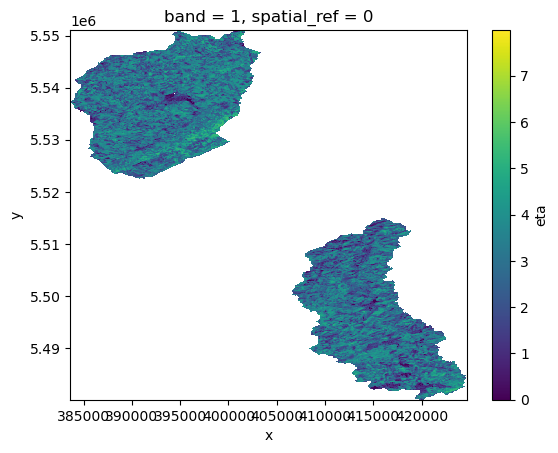

In [46]:
eeflux.plot()

In [45]:
export_path = path_data + "Processed/METRIC_raster_export/METRIC_" + date_SSEB + ".tif"
raster = eeflux  # xarray Array to be exported

raster.rio.to_raster(export_path)

### Scatterplot, simple statistics

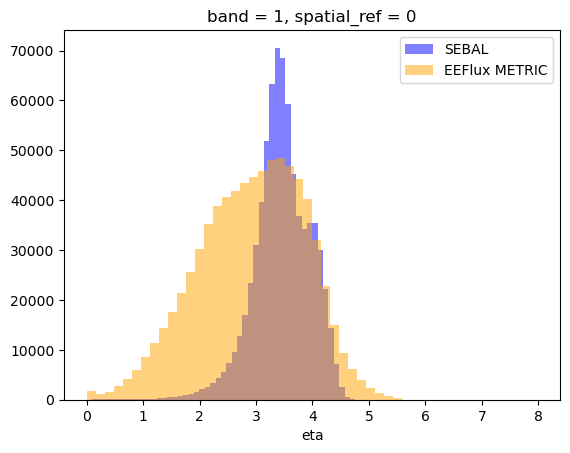

In [47]:
eta_day.plot.hist(bins = 50, alpha = 0.5, color = "blue", label = "SEBAL")
eeflux.plot.hist(bins = 50, alpha = 0.5, color = "orange", label = "EEFlux METRIC")
plt.legend(loc='upper right')
plt.show()

Slope: 1.197647403392452
Intercept: -1.211776124524028
R-squared value: 0.40734987708280634
P-value: 0.0
Standard error: 0.0016752917547020805


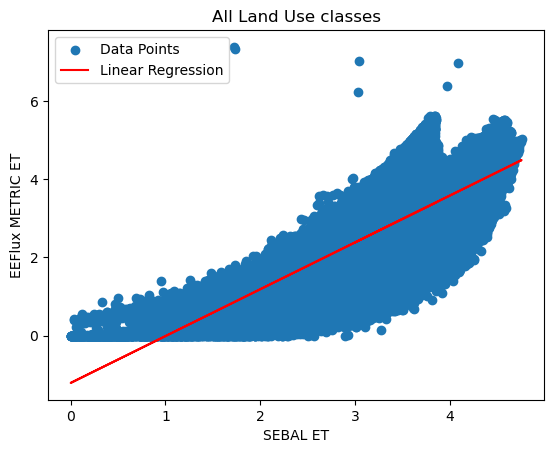

In [48]:
### Define Datasets 

title = "All Land Use classes"
x_name = "SEBAL ET"
y_name = "EEFlux METRIC ET"

x_values = eta_day.values
y_values = eeflux.values

# Remove NaN values
mask = ~np.isnan(x_values) & ~np.isnan(y_values)
x_values = x_values[mask]
y_values = y_values[mask]



### Linear Regression and Coefficients 
slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared value: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard error: {std_err}")


### Plot Regression
plt.scatter(x_values, y_values, label='Data Points')

# Plot the regression line
regression_line = slope * x_values + intercept
plt.plot(x_values, regression_line, color='red', label='Linear Regression')

# Labeling the plot
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.title(title)
plt.legend()

# Show the plot
plt.show()

# Results in List
EEFlux_fullreg.extend((slope, intercept, r_value**2, p_value, std_err))


Slope: 1.0918257028755445
Intercept: -0.6988383911839975
R-squared value: 0.40397336417209595
P-value: 0.0
Standard error: 0.00262022669649157


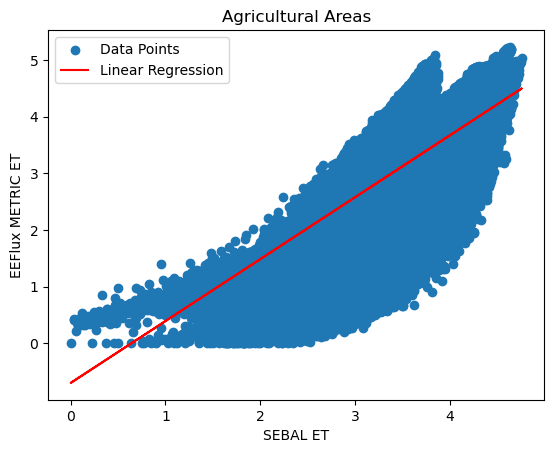

In [49]:
### Define Datasets 
title = "Agricultural Areas"
x_name = "SEBAL ET"
y_name = "EEFlux METRIC ET"

x_values = eta_day.where(agri_filter).values
y_values = eeflux.where(agri_filter).values

# Remove NaN values
mask = ~np.isnan(x_values) & ~np.isnan(y_values)
x_values = x_values[mask]
y_values = y_values[mask]



### Linear Regression and Coefficients 
slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared value: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard error: {std_err}")


### Plot Regression
plt.scatter(x_values, y_values, label='Data Points')

# Plot the regression line
regression_line = slope * x_values + intercept
plt.plot(x_values, regression_line, color='red', label='Linear Regression')

# Labeling the plot
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.title(title)
plt.legend()

# Show the plot
plt.show()

# Results into List
EEFlux_agri.extend((slope, intercept, r_value**2, p_value, std_err))

Slope: 0.9514129401269262
Intercept: -0.5549851008101658
R-squared value: 0.2697620495505762
P-value: 0.0
Standard error: 0.003776112325137546


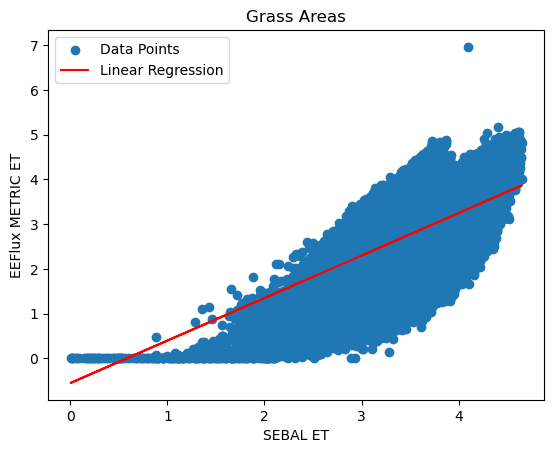

In [50]:
### Define Datasets 
title = "Grass Areas"
x_name = "SEBAL ET"
y_name = "EEFlux METRIC ET"

x_values = eta_day.where(grass_filter).values
y_values = eeflux.where(grass_filter).values

# Remove NaN values
mask = ~np.isnan(x_values) & ~np.isnan(y_values)
x_values = x_values[mask]
y_values = y_values[mask]



### Linear Regression and Coefficients 
slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared value: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard error: {std_err}")


### Plot Regression
plt.scatter(x_values, y_values, label='Data Points')

# Plot the regression line
regression_line = slope * x_values + intercept
plt.plot(x_values, regression_line, color='red', label='Linear Regression')

# Labeling the plot
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.title(title)
plt.legend()

# Show the plot
plt.show()

# Results into List
EEFlux_grass.extend((slope, intercept, r_value**2, p_value, std_err))

Slope: 1.3581276476319704
Intercept: -1.7014561876083523
R-squared value: 0.38267417414510924
P-value: 0.0
Standard error: 0.0032579047156699415


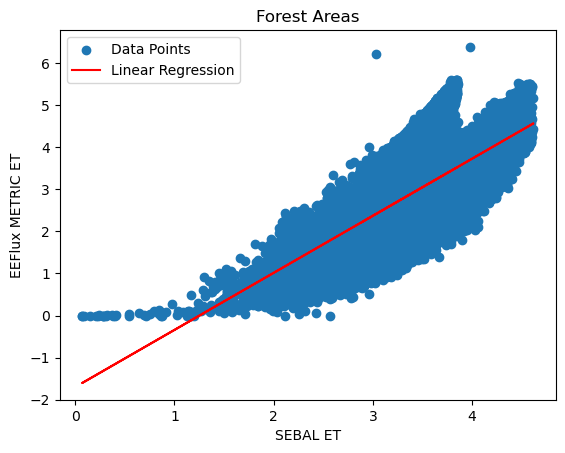

In [51]:
### Define Datasets 
title = "Forest Areas"
x_name = "SEBAL ET"
y_name = "EEFlux METRIC ET"

x_values = eta_day.where(forest_filter).values
y_values = eeflux.where(forest_filter).values

# Remove NaN values
mask = ~np.isnan(x_values) & ~np.isnan(y_values)
x_values = x_values[mask]
y_values = y_values[mask]



### Linear Regression and Coefficients 
slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared value: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard error: {std_err}")


### Plot Regression
plt.scatter(x_values, y_values, label='Data Points')

# Plot the regression line
regression_line = slope * x_values + intercept
plt.plot(x_values, regression_line, color='red', label='Linear Regression')

# Labeling the plot
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.title(title)
plt.legend()

# Show the plot
plt.show()

# Results into List
EEFlux_forest.extend((slope, intercept, r_value**2, p_value, std_err))

Slope: 1.6821070124965283
Intercept: -3.187355359016412
R-squared value: 0.7553873248621876
P-value: 2.0248454911811603e-146
Standard error: 0.0440592656148654


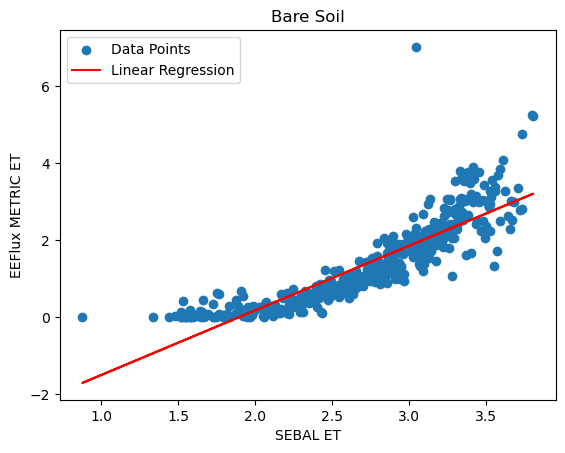

In [52]:
### Define Datasets 
title = "Bare Soil"
x_name = "SEBAL ET"
y_name = "EEFlux METRIC ET"

x_values = eta_day.where(bare_filter).values
y_values = eeflux.where(bare_filter).values

# Remove NaN values
mask = ~np.isnan(x_values) & ~np.isnan(y_values)
x_values = x_values[mask]
y_values = y_values[mask]



### Linear Regression and Coefficients 
slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared value: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard error: {std_err}")


### Plot Regression
plt.scatter(x_values, y_values, label='Data Points')

# Plot the regression line
regression_line = slope * x_values + intercept
plt.plot(x_values, regression_line, color='red', label='Linear Regression')

# Labeling the plot
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.title(title)
plt.legend()

# Show the plot
plt.show()

# Results into List
EEFlux_bare.extend((slope, intercept, r_value**2, p_value, std_err))

Slope: 0.8377033979478749
Intercept: -0.7447660331575678
R-squared value: 0.5026636623817479
P-value: 0.0
Standard error: 0.004473004907961729


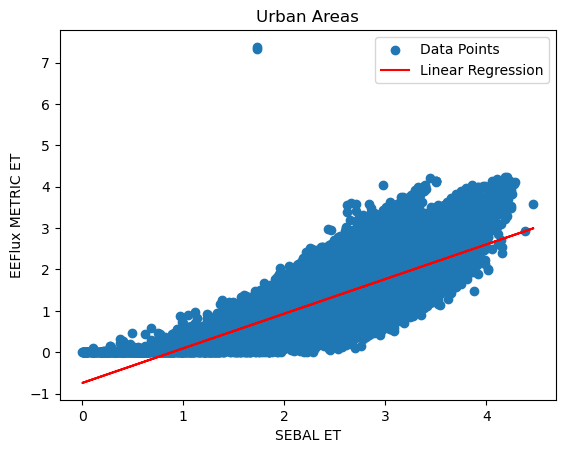

In [53]:
### Define Datasets 
title = "Urban Areas"
x_name = "SEBAL ET"
y_name = "EEFlux METRIC ET"

x_values = eta_day.where(urban_filter).values
y_values = eeflux.where(urban_filter).values

# Remove NaN values
mask = ~np.isnan(x_values) & ~np.isnan(y_values)
x_values = x_values[mask]
y_values = y_values[mask]



### Linear Regression and Coefficients 
slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared value: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard error: {std_err}")


### Plot Regression
plt.scatter(x_values, y_values, label='Data Points')

# Plot the regression line
regression_line = slope * x_values + intercept
plt.plot(x_values, regression_line, color='red', label='Linear Regression')

# Labeling the plot
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.title(title)
plt.legend()

# Show the plot
plt.show()

# Results into List
EEFlux_urban.extend((slope, intercept, r_value**2, p_value, std_err))

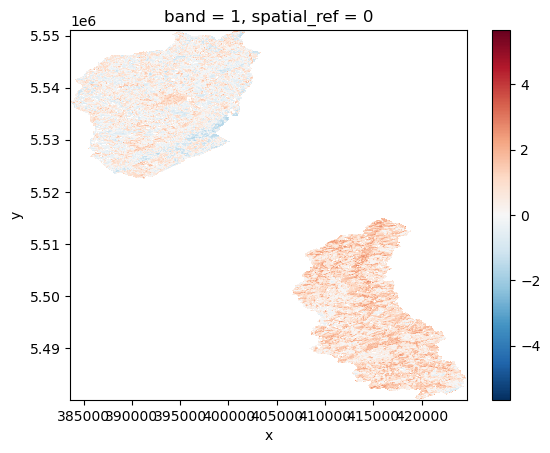

In [54]:
# Difference raster
diff = eta_day - eeflux
diff.plot()

### SPAEF EEFlux

In [55]:
SPAEF(eeflux.values, eta_day.values)

(-0.5379822686839983,
 0.6382396705649113,
 2.2157397542009094,
 0.13023234545718634)

In [56]:
SPAEF(eta_day.values, eeflux.values)

(-0.09014670931277835,
 0.6382396705649112,
 0.45131654026789925,
 0.13023234545718634)

# Regression Table

In [57]:
land_use_reg = [WASIM_agri, SSEB_agri, EEFlux_agri, 
                WASIM_bare, SSEB_bare, EEFlux_bare, 
                WASIM_grass, SSEB_grass, EEFlux_grass,
                WASIM_urban, SSEB_urban, EEFlux_urban,
                WASIM_forest, SSEB_forest, EEFlux_forest 
                ]



In [58]:
land_use_names = ["WASIM_agri", "SSEB_agri", "EEFlux_agri", 
                "WASIM_bare", "SSEB_bare", "EEFlux_bare", 
                "WASIM_grass", "SSEB_grass", "EEFlux_grass",
                "WASIM_urban", "SSEB_urban", "EEFlux_urban",
                "WASIM_forest", "SSEB_forest", "EEFlux_forest" 
                ]

modelnames = ["WASIM", "SSEB", "EEFlux"] * 5

land_use_class = ["Agriculture"]*3+["BareSoil"]*3+["Grass"]*3+["Urban"]*3+["Forest"]*3

In [59]:
parameters = ["slope", "intercept", "r_sqrd", "p_value", "std_err"]

full_regressions = pd.DataFrame({
    "Parameter": parameters,
    "WASIM": WASIM_fullreg,
    "SSEB": SSEB_fullreg})

full_regressions

,Parameter,WASIM,SSEB
0,slope,0.064706,0.927705
1,intercept,2.662210,-0.434509
2,r_sqrd,0.029339,0.635892
3,p_value,0.000000,0.000000
4,std_err,0.000592,0.000814


In [60]:
colnames = ["Model", "LandUse", "slope", "intercept", "r_sqrd", "p_value", "std_err"]

df = pd.DataFrame(columns=colnames)

list = []

for i in range(0,len(land_use_class)):
    list = [modelnames[i]]
    list.append(land_use_class[i])
    list.extend(land_use_reg[i])
    df.loc[i] = list
    
df

,Model,LandUse,slope,intercept,r_sqrd,p_value,std_err
0,WASIM,Agriculture,-0.038435,3.041655,0.032680,0.000000e+00,0.000563
1,SSEB,Agriculture,0.998216,-0.735789,0.606411,0.000000e+00,0.001589
2,EEFlux,Agriculture,1.091826,-0.698838,0.403973,0.000000e+00,0.002620
3,WASIM,BareSoil,-0.071985,2.877888,0.203180,4.249621e-25,0.006562
4,SSEB,BareSoil,0.610497,0.128250,0.697263,1.493536e-124,0.018516
5,EEFlux,BareSoil,1.682107,-3.187355,0.755387,2.024845e-146,0.044059
6,WASIM,Grass,0.055119,2.821762,0.011152,3.377945e-193,0.001854
7,SSEB,Grass,0.842654,-0.226980,0.592942,0.000000e+00,0.001684
8,EEFlux,Grass,0.951413,-0.554985,0.269762,0.000000e+00,0.003776
9,WASIM,Urban,0.001772,2.675814,0.000126,1.569061e-01,0.001252


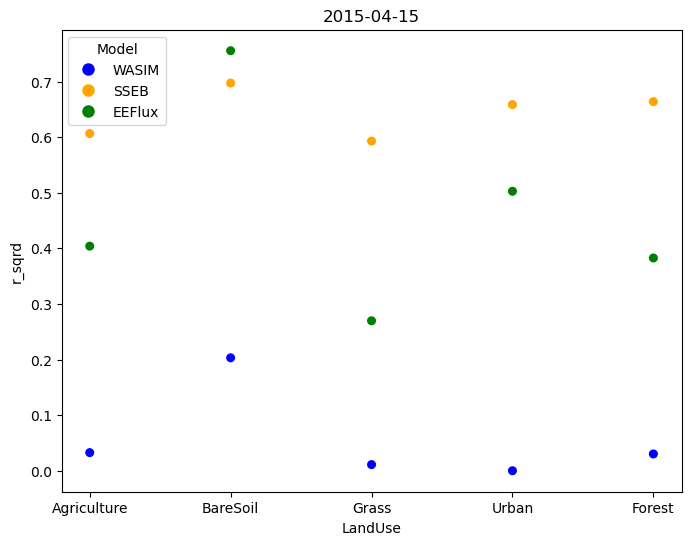

In [61]:
colors = {"WASIM": "blue", "SSEB": "orange", "EEFlux": "green"}

# Scatter plot
scatter_plot = df.plot.scatter(x="LandUse", y="r_sqrd", c=df["Model"].map(colors), figsize=(8, 6), s = 30)

# Create a legend
legend_labels = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=10) for label, color in colors.items()]
scatter_plot.legend(handles=legend_labels, title="Model")

# Set the title
scatter_plot.set_title(date_met)

# EXPORT
# Save the plot as a .png file
plot_filename = path_plots+f"r_sqrd_{date_met}.png"
plt.savefig(plot_filename)

plt.show()

### Correlation Matrix

In [62]:
# Correlation Matrix
ds = xr.Dataset({"SEBAL": eta_day, "WASIM": wasim, 
                     "SSEB": SSEB_raster, "EEFlux": eeflux})

correlation_matrix = ds.to_dataframe().corr()
correlation_matrix = correlation_matrix.iloc[2:6,2:6]
#xr.corr(eta_day, wasim)
correlation_matrix

,SEBAL,WASIM,SSEB,EEFlux
SEBAL,1.000000,0.171286,0.797428,0.638240
WASIM,0.171286,1.000000,0.061917,0.130694
SSEB,0.797428,0.061917,1.000000,0.810263
EEFlux,0.638240,0.130694,0.810263,1.000000


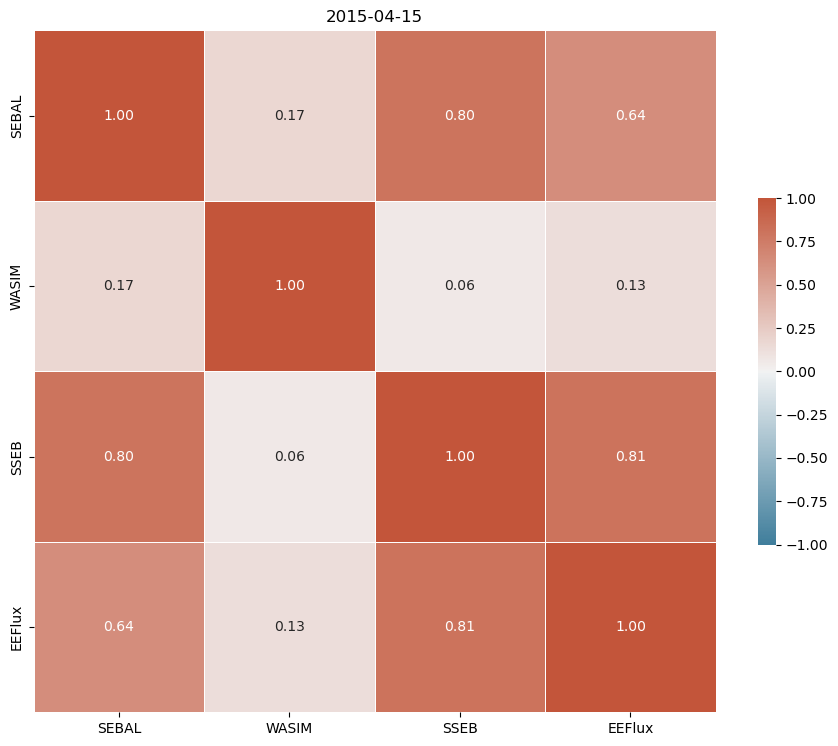

In [63]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the full correlation matrix heatmap with annotations
correlation_matrix_plot = sns.heatmap(correlation_matrix, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, annot=True, fmt=".2f", cbar_kws={"shrink": .5})

# Set the title
correlation_matrix_plot.set_title(date_met)

# EXPORT
# Save the plot as a .png file
plot_filename = path_plots+f"corr_{date_met}.png"
plt.savefig(plot_filename)

# Show the plot
plt.show()



# Export Plots